In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [4]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives, calc_decay_windows, _halflife
from jtb_2022_code import FigureSingleCellData
from inferelator_velocity import decay
import numpy as np
import pandas as pd

In [5]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()
data.load_pseudotime(do_rho=False)

# Copy cell cycle time to main object
data.all_data.obs['program_cc_time'] = 0
for _, e in data.expt_data.items():
    data.all_data.obs.loc[e.obs_names, 'program_cc_time'] = e.obs['program_cc_time']

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [ ]:
# Load velocity data
velo_arr = np.vstack([data.velocity_data(i, "WT").layers['cell_cycle_velocity'] for i in range(1, 3)])
velo_times = np.hstack([data.expt_data[(i, "WT")].obs['program_cc_time'].values for i in range(1, 3)])
velo_12_idx =  np.hstack([(data.expt_data[(i, "WT")].obs['Pool_Combined'] == '12').values for i in range(1, 3)])

#denoised_arr = np.vstack([data.denoised_data(i, "WT").X for i in range(1, 3)])
#denoised_times = np.hstack([data.expt_data[(i, "WT")].obs['program_cc_time'].values for i in range(1, 3)])
#denoised_12_idx =  np.hstack([(data.expt_data[(i, "WT")].obs['Pool_Combined'] == '12').values for i in range(1, 3)])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import inferelator_velocity as ifv

rgen = np.random.default_rng(100)

rep_colors = ['darkslateblue', 'darkgoldenrod']

panel_labels = {'schematic': "A",
                'expr_1': "B",
                'velocity_1': "C",
                'decay_1': "D",
                'decaytime_1': "E"}

layout = [['expr', 'velo', 'cc_cbar']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 0.1], 
                                               height_ratios=[1],
                                               wspace=0.25, hspace=0.5), 
                              figsize=(6, 2), dpi=300)

add_legend(axd['cc_cbar'], cc_palette(), CC_COLS, title="Phase", fontsize='x-small')

_wt_idx = (data.all_data.obs['Gene'] == "WT").values
#_12_idx = ((data.all_data.obs['Pool'] == 1 ) | (data.all_data.obs['Pool'] == 2)).values

for i, cc in enumerate(CC_COLS):
    _cc_idx = data.all_data.var[cc]
    
    ### EXPRESSION ###
    _cc_data = data.all_data.layers['counts'][:, _cc_idx].astype(float).A
    _cc_data /= data.all_data.obs['n_counts'].values[:, np.newaxis]
    _cc_data = np.sum(_cc_data, axis=1)
    
    #_cc_data = np.sum(denoised_arr[:, _cc_idx], axis=1)
    
    #times = data.all_data.obs['program_cc_time'].values[_wt_idx]
    times = data.all_data.obs['program_cc_time'].values[_wt_idx]
    times = (times + 44) % 88

    _cc_data, _cc_time = ifv.utils.aggregate_sliding_window_times(
        _cc_data[_wt_idx][velo_12_idx],
        times[velo_12_idx],
        centers=np.linspace(0.5, CC_LENGTH - 0.5, int(CC_LENGTH / 2)),
        width=2.,
        agg_func=(np.mean, np.std)
    )
    
    #_cc_data, _cc_time = aggregate_sliding_window_times(
    #    _cc_data,
    #    denoised_times,
    #    centers=np.linspace(0.5, CC_LENGTH - 0.5, int(CC_LENGTH / 2)),
    #    width=2.,
    #    agg_func=(np.mean, np.std)
    #)

    _cc_data = _cc_data / _cc_data[:, 0].max()

    axd['expr'].plot(_cc_time,
                 _cc_data[:, 0], 
                 alpha=0.7,
                 marker=".", 
                 linestyle='-', 
                 color=cc_palette()[i]
                )

    #axd['expr'].fill_between(_cc_time,
    #             _cc_data[:, 0] - _cc_data[:, 1], 
    #             _cc_data[:, 0] + _cc_data[:, 1], 
    #             alpha=0.2,
    #             color=cc_palette()[i]
    #            )

    axd['expr'].set_xlim(0, CC_LENGTH)
    axd['expr'].set_ylim(0, 1)
    axd['expr'].set_yticks([0.0, 0.5, 1.0])
    axd['expr'].set_xticks([7, 22, 40, 57, 78])
    axd['expr'].set_title("Expression")
    
    vtimes = (velo_times + 44) % 88
    
    ### VELOCITY ###
    _cc_data, _cc_time = ifv.utils.aggregate_sliding_window_times(
        #velo_arr[:, _cc_idx], 
        velo_arr[velo_12_idx, :][:, _cc_idx],
        #velo_times, 
        vtimes[velo_12_idx],
        centers=np.linspace(0.5, CC_LENGTH - 0.5, CC_LENGTH),
        width=1.,
        agg_func=(np.mean, np.std)
    )
    
    #_cc_data[_cc_data[:, 0] >= 0] /= _cc_data[_cc_data[:, 0] >= 0, 0].max()
    #_cc_data[_cc_data[:, 0] < 0] /=_cc_data[_cc_data[:, 0] < 0, 0].min() * -1
    _cc_data /= np.abs(_cc_data[:, 0]).max()
    
    axd['velo'].plot(_cc_time,
                 _cc_data[:, 0], 
                 alpha=0.7,
                 marker=".", 
                 linestyle='-', 
                 color=cc_palette()[i]
                )
    
    axd['velo'].set_xlim(0, CC_LENGTH)
    axd['velo'].set_ylim(-1, 1)
    axd['velo'].set_yticks([-1, 0.0,1.0])
    axd['velo'].set_xticks([7, 22, 40, 57, 78])
    axd['velo'].set_title("Velocity")

In [6]:
import numpy as _np
from scipy.sparse import issparse as _is_sparse
from tqdm import trange

def calc_velocity(expr, time_axis, neighbor_graph, wrap_time=None):
    """
    Calculate local RNA velocity

    :param expr: Samples x Genes numpy with expression data
    :param time_axis: Samples, numpy array
    :param neighbor_graph: Samples x Samples numpy or scipy.sparse with nearest neighbor distances
    :return: Samples x Genes numpy with velocity data
    """

    times = [_calc_local_velocity(expr[n_idx, :].copy(),
                                  time_axis[n_idx].copy(),
                                  (n_idx == i).nonzero()[0][0],
                                  wrap_time=wrap_time)
             for i, n_idx in _find_local(expr, neighbor_graph)]
    
    shape_1 = max(map(len, times))
    
    times = [np.concatenate((x, np.zeros(shape_1 - len(x), dtype=float)))
             for x in times]
    
    return np.vstack(times)


def _calc_local_velocity(expr, time_axis, center_index, wrap_time=None):
    """
    Calculate a local rate of change

    :param expr: Samples x Genes numpy with expression data
    :param time_axis: Samples, numpy array
    :param center_index: The data point which we're calculating velocity for
    :return:
    """

    n, m = expr.shape

    if _np.isnan(time_axis[center_index]):
        return _np.full(m, _np.nan)

    time_axis = time_axis - time_axis[center_index]

    if wrap_time is not None:
        time_axis = _wrap_time(time_axis, wrap_time)

    return time_axis


def _find_local(expr, neighbor_graph):
    """
    Find a return an expression matrix for a locally connected graph

    :param expr: Samples x Genes numpy or scipy with expression data
    :type expr: np.ndarray, sp.sparse.csr_matrix
    :param neighbor_graph: Samples x Samples connectivity matrix,
        where any non-zero value is connected.
    :return:
    """

    n, m = expr.shape
    neighbor_sparse = _is_sparse(neighbor_graph)

    for i in trange(n):

        n_slice = neighbor_graph[i, :]

        if neighbor_sparse:
            keepers = n_slice.indices
        else:
            keepers = _np.where(n_slice != 0)[0]

        if all(keepers != i):
            keepers = _np.insert(keepers, 0, i)

        yield i, keepers


def _wrap_time(times, wrap_time):
    """
    Wrap times by taking the minimum time difference
    with and without wrapping

    :param times: Centered time vector
    :type times: np.ndarray
    :param wrap_time: Time to wrap at
    :type wrap_time: numeric
    :return: Wrapped time vector
    :rtype: np.ndarray
    """

    times = _np.vstack((
        times + wrap_time,
        times,
        times - wrap_time
    ))

    times = times[
        _np.argmin(
            _np.abs(times),
            axis=0
        ),
        _np.arange(
            times.shape[1]
        )
    ]

    return times


In [7]:
denoised_1 = data.denoised_data(1, "WT")
denoised_1

Loading denoised data from /scratch/cj59/RAPA/2021_RAPA_DENOISED_FIGS_1_WT.h5ad


AnnData object with n_obs × n_vars = 63533 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'Pool_Combined', 'program_0_time', 'program_1_time', 'program_rapa_time', 'program_cc_time', 'denoised_leiden', 'denoised_n'
    var: 'n_cells', 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'Cell Cycle', 'Other', 'category', 'program', 'denoised_SNR', 'denoised_variance'
    uns: 'denoised', 'denoised_SNR', 'denoised_variance', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'denoised_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'denoised_connectivities', 'denoised_distances', 'denoised_graph', 'distances', 'optimal_distances'

In [16]:
for e, g in data.expt_data.keys():
    data.expt_data[e, g].obs[['Pool', 'CC', 'program_rapa_time', 'program_cc_time']].to_csv(f"/scratch/cj59/RAPA/RAPA_DENOISED_{e}_{g}_metadata.tsv.gz", sep="\t")

In [ ]:
data.expt_data[1, "WT"]

In [8]:
#graph = denoised_1.obsp['denoised_distances']
graph = data.expt_data[1, "WT"].obsp['program_cc_distances']

t = calc_velocity(denoised_1.X,
                  data.expt_data[1, "WT"].obs['program_cc_time'],
                  graph)

t_min = np.argsort(data.expt_data[1, "WT"].obs['program_cc_time'])[0]
t = t[np.argsort(data.expt_data[1, "WT"].obs['program_cc_time']), :]

twrap = calc_velocity(denoised_1.X,
                  data.expt_data[1, "WT"].obs['program_cc_time'],
                  graph,
                  wrap_time=88)

twrap = twrap[np.argsort(data.expt_data[1, "WT"].obs['program_cc_time']), :]


100%|██████████| 63533/63533 [01:06<00:00, 961.37it/s]


<AxesSubplot:xlabel='program_cc_time'>

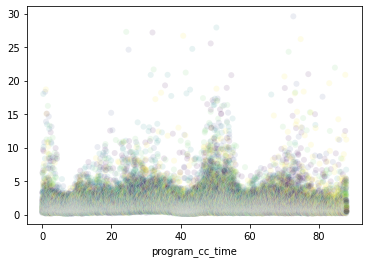

In [15]:
import seaborn as sns

sns.scatterplot(x=data.expt_data[1, "WT"].obs['program_cc_time'].iloc[np.argsort(data.expt_data[1, "WT"].obs['program_cc_time'])],
                y=np.abs(twrap).mean(axis=1),
                c=data.expt_data[1, "WT"].obs['CC'].cat.codes, alpha=0.1)

In [ ]:
loc = t.shape[0]

In [ ]:
np.abs(twrap[loc - 100:loc-1, :]).mean(axis=1)

In [ ]:
data.expt_data[1, "WT"].obs['program_cc_time'].iloc[t_min]

In [ ]:
data.expt_data[1, "WT"].obs['program_cc_time'].iloc[denoised_1.obsp['denoised_distances'][t_min, :].indices]

In [ ]:
t